# Librerias

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import roc_auc_score, f1_score, cohen_kappa_score, accuracy_score, balanced_accuracy_score, recall_score, precision_score, balanced_accuracy_score, make_scorer, matthews_corrcoef

from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import confusion_matrix
from sklearn import metrics

from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder

from statsmodels.stats.multitest import multipletests

# Datos

In [2]:
pre_path = "../../../../data/radiomic_data/"

In [3]:
data_path = pre_path + "concatenated_data/" + "features_all_gland.csv"

In [4]:
df = pd.read_csv(data_path)
df['patient_id_study_id'] = df['patient_id'].astype(str) + '_' + df['study_id'].astype(str)
df = df.set_index('patient_id_study_id')

# Split data

In [5]:
from sklearn.model_selection import StratifiedGroupKFold

y = df["label"]
groups = df.patient_id
X = df[[col for col in df.columns 
        if col not in ['patient_id', 'study_id', 'label']]]

In [6]:
random_state_value = 1234

print_information = False

sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=random_state_value)
sgkf.split(X, y, groups)
train_index, test_index = next(sgkf.split(X, y, groups))
if print_information:
    print(f"  Train: index={train_index}")
    print(f"         size={len(train_index)}")
    print(f"         group={groups[train_index]}")
    print(f"  Test:  index={test_index}")
    print(f"         size={len(test_index)}")
    print(f"         group={groups[test_index]}")

X_train = X.iloc[train_index]
Y_train = y.iloc[train_index]

X_test = X.iloc[test_index]
Y_test = y.iloc[test_index]

le = LabelEncoder()
y_train = le.fit_transform(Y_train)
y_test = le.transform(Y_test)

display(X_train)
display(Y_train)
display(y_train)

,adc_original_shape_Elongation,adc_original_shape_Flatness,adc_original_shape_LeastAxisLength,adc_original_shape_MajorAxisLength,adc_original_shape_Maximum2DDiameterColumn,adc_original_shape_Maximum2DDiameterRow,adc_original_shape_Maximum2DDiameterSlice,adc_original_shape_Maximum3DDiameter,adc_original_shape_MeshVolume,adc_original_shape_MinorAxisLength,...,t2_exponential_gldm_GrayLevelNonUniformity,t2_exponential_gldm_GrayLevelVariance,t2_exponential_gldm_HighGrayLevelEmphasis,t2_exponential_gldm_LargeDependenceEmphasis,t2_exponential_gldm_LargeDependenceHighGrayLevelEmphasis,t2_exponential_gldm_LargeDependenceLowGrayLevelEmphasis,t2_exponential_gldm_LowGrayLevelEmphasis,t2_exponential_gldm_SmallDependenceEmphasis,t2_exponential_gldm_SmallDependenceHighGrayLevelEmphasis,t2_exponential_gldm_SmallDependenceLowGrayLevelEmphasis
patient_id_study_id,,,,,,,,,,,,,,,,,,,,,
10000_1000000,0.808087,0.633421,29.132328,45.992060,52.023421,45.423126,52.050928,52.155433,34596.941996,37.165588,...,60127.673168,0.028000,1.048730,78.122638,78.918905,78.030621,0.995408,0.013927,0.020408,0.013329
10001_1000001,0.862442,0.764552,44.203477,57.816184,64.509395,64.791501,63.803018,68.505758,90203.160327,49.863125,...,139894.070996,0.000528,1.001557,79.162458,79.205704,79.151655,0.999619,0.013044,0.013234,0.013005
10002_1000002,0.980027,0.814579,40.404389,49.601552,55.095586,57.791057,56.759056,59.664486,68950.891538,48.610866,...,117629.356071,0.145071,1.272186,76.342860,83.702612,74.954786,0.964784,0.016139,0.076518,0.013551
10004_1000004,0.852145,0.637281,34.380191,53.948227,60.310477,57.723667,60.055545,60.764832,60276.919709,45.971733,...,94406.183813,0.010063,1.018443,78.676255,78.972203,78.623897,0.997771,0.013463,0.018503,0.013148
10005_1000005,0.825865,0.776633,39.323145,50.632868,59.411393,49.641503,59.797364,59.872571,57488.371713,41.815928,...,104790.355440,0.007254,1.021922,78.389992,79.295271,78.163672,0.994520,0.013481,0.014627,0.013194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11470_1001494,0.852054,0.760275,32.752101,43.079278,50.721704,46.239147,50.372505,51.973274,35425.043292,36.705853,...,67173.922105,0.070730,1.113226,77.695537,79.282519,77.471623,0.990791,0.014786,0.044466,0.013394
11471_1001495,0.878505,0.737381,36.317429,49.251941,56.065829,52.513226,58.636140,58.740505,51458.060433,43.268071,...,82269.382031,0.005180,1.014790,78.475659,79.026015,78.340754,0.996524,0.013452,0.014564,0.013223
11473_1001497,0.892180,0.738870,39.542375,53.517373,54.950399,64.840167,56.607416,65.262994,72322.299772,47.747125,...,108585.096271,0.058213,1.100875,78.283417,80.474545,78.057671,0.990907,0.014341,0.030646,0.013171


patient_id_study_id
10000_1000000    0
10001_1000001    0
10002_1000002    0
10004_1000004    0
10005_1000005    1
                ..
11470_1001494    0
11471_1001495    1
11473_1001497    0
11474_1001498    0
11475_1001499    1
Name: label, Length: 1128, dtype: int64

array([0, 0, 0, ..., 0, 0, 1])

# Perform univariable analysis on training set

In [7]:
from scipy.stats import shapiro, mannwhitneyu, ttest_ind

feature_names, sensitivity_list, specificity_list, auc_list, threshold_list, test_type_list, pvalue_list, pos_vs_neg_list = ([] for i in range(8))
for column in X_train:
  # normality test
  stat, p = shapiro(X_train[column])
  # print('Name ', column)
  # print('Statistics=%.3f, p=%.3f' % (stat, p))
  a_dist = X_train[column][y_train==0]
  b_dist = X_train[column][y_train==1]
  feature_names.append(column)
  # interpret
  alpha = 0.05
  if p > alpha:
    test_type_list.append('t-test')
    stats, pval = ttest_ind(a_dist, b_dist)
    # print('Sample looks Gaussian (fail to reject H0)')
  else:
    test_type_list.append('mann-whitney U-test')
    stats, pval = mannwhitneyu(a_dist, b_dist)
    # print('Sample does not look Gaussian (reject H0)')
  pvalue_list.append(pval)
  fpr, tpr, thresholds = metrics.roc_curve(y_train, X_train[column], pos_label=1)
  auc = metrics.auc(fpr, tpr)
  pos_vs_neg = ">"
  if auc <0.5:
    fpr, tpr, thresholds = metrics.roc_curve(y_train, X_train[column], 
                                             pos_label=0)
    auc = metrics.auc(fpr, tpr)
    pos_vs_neg = "<"
  auc_list.append(auc)
  pos_vs_neg_list.append(pos_vs_neg)
  ####################################
  # The optimal cut off would be where tpr is high and fpr is low
  # tpr - (1-fpr) is zero or near to zero is the optimal cut off point
  ####################################
  i = np.arange(len(tpr)) # index for df
  roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
  cutoff_df = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

  sensitivity_list.append(cutoff_df['tpr'].values[0])
  specificity_list.append(cutoff_df['1-fpr'].values[0])
  threshold_list.append(cutoff_df['thresholds'].values[0])

train_auc_pvals_df = pd.DataFrame(list(zip(auc_list, pos_vs_neg_list,threshold_list, 
                                           sensitivity_list, specificity_list, 
                                           test_type_list, pvalue_list)), 
                                  index = feature_names,
                                  columns =['AUC', 'Pos.vs.Neg.', 
                                            'Cutoff-Threshold', 'Sensitivity', 
                                            'Specificity', 'Test', 'p-value'])

train_auc_pvals_df.sort_values(by='p-value', ascending=True)

,AUC,Pos.vs.Neg.,Cutoff-Threshold,Sensitivity,Specificity,Test,p-value
dwi_square_ngtdm_Strength,0.753307,>,0.482714,0.681250,0.681931,mann-whitney U-test,3.061214e-40
dwi_exponential_glcm_Imc1,0.734653,<,-0.247731,0.683168,0.684375,mann-whitney U-test,4.852319e-35
dwi_log-sigma-3-mm-3D_firstorder_Skewness,0.731695,<,-0.780318,0.674505,0.675000,mann-whitney U-test,6.016631e-34
dwi_exponential_glszm_GrayLevelNonUniformityNormalized,0.727702,<,0.349438,0.691832,0.687500,mann-whitney U-test,4.287320e-33
dwi_exponential_ngtdm_Strength,0.721952,>,1.054566,0.684375,0.680693,mann-whitney U-test,1.578772e-31
...,...,...,...,...,...,...,...
t2_log-sigma-3-mm-3D_glrlm_RunPercentage,0.500085,<,0.250321,0.502475,0.503125,mann-whitney U-test,9.965219e-01
adc_exponential_firstorder_Variance,0.500062,>,1260.607867,0.478125,0.477723,mann-whitney U-test,9.974925e-01
adc_wavelet-HL_glcm_InverseVariance,0.500050,<,0.450429,0.500000,0.496875,mann-whitney U-test,9.979779e-01
adc_exponential_glrlm_ShortRunEmphasis,0.500031,>,0.401759,0.496875,0.497525,mann-whitney U-test,9.987867e-01


In [8]:
print(sum(i < 0.05 for i in train_auc_pvals_df['p-value']))

2807


In [9]:
_, corrected_p_value, _, _ = multipletests(train_auc_pvals_df['p-value'], 
                                           alpha=0.05, method='bonferroni')

train_auc_pvals_corrected_df = pd.DataFrame(list(zip(auc_list, pos_vs_neg_list, 
                                                     threshold_list, 
                                                     sensitivity_list, 
                                                     specificity_list, 
                                                     test_type_list, 
                                                     pvalue_list, 
                                                     corrected_p_value)), 
                                  index = feature_names,
                                  columns =['AUC', 'Pos.vs.Neg.', 
                                            'Cutoff-Threshold', 'Sensitivity', 
                                            'Specificity', 'Test', 'p-value',
                                            'corrected p-value'])
train_auc_pvals_corrected_df.sort_values(by='corrected p-value', ascending=True)

,AUC,Pos.vs.Neg.,Cutoff-Threshold,Sensitivity,Specificity,Test,p-value,corrected p-value
dwi_square_ngtdm_Strength,0.753307,>,0.482714,0.681250,0.681931,mann-whitney U-test,3.061214e-40,1.293975e-36
dwi_exponential_glcm_Imc1,0.734653,<,-0.247731,0.683168,0.684375,mann-whitney U-test,4.852319e-35,2.051075e-31
dwi_log-sigma-3-mm-3D_firstorder_Skewness,0.731695,<,-0.780318,0.674505,0.675000,mann-whitney U-test,6.016631e-34,2.543230e-30
dwi_exponential_glszm_GrayLevelNonUniformityNormalized,0.727702,<,0.349438,0.691832,0.687500,mann-whitney U-test,4.287320e-33,1.812250e-29
dwi_exponential_ngtdm_Strength,0.721952,>,1.054566,0.684375,0.680693,mann-whitney U-test,1.578772e-31,6.673468e-28
...,...,...,...,...,...,...,...,...
adc_original_glcm_DifferenceAverage,0.535168,>,2.142373,0.515625,0.516089,mann-whitney U-test,6.525409e-02,1.000000e+00
adc_original_glcm_DifferenceEntropy,0.533629,>,2.689737,0.512500,0.512376,mann-whitney U-test,7.793111e-02,1.000000e+00
adc_original_glcm_DifferenceVariance,0.519423,>,4.508360,0.512500,0.509901,mann-whitney U-test,3.086237e-01,1.000000e+00
adc_original_glcm_Id,0.542957,<,0.460480,0.525990,0.528125,mann-whitney U-test,2.433151e-02,1.000000e+00


In [10]:
train_auc_pvals_corrected_df.sort_values(by='corrected p-value', ascending=True).index[0:20]

Index(['dwi_square_ngtdm_Strength', 'dwi_exponential_glcm_Imc1',
       'dwi_log-sigma-3-mm-3D_firstorder_Skewness',
       'dwi_exponential_glszm_GrayLevelNonUniformityNormalized',
       'dwi_exponential_ngtdm_Strength',
       'dwi_log-sigma-3-mm-3D_firstorder_Kurtosis',
       'dwi_exponential_glszm_GrayLevelVariance',
       'dwi_square_firstorder_Skewness', 'dwi_exponential_firstorder_Skewness',
       'dwi_exponential_glcm_ClusterProminence',
       'dwi_exponential_glszm_HighGrayLevelZoneEmphasis',
       'dwi_wavelet2-LL_firstorder_Skewness',
       'dwi_exponential_glrlm_GrayLevelVariance',
       'dwi_exponential_glcm_ClusterShade',
       'dwi_exponential_glszm_SmallAreaHighGrayLevelEmphasis',
       'dwi_exponential_gldm_SmallDependenceHighGrayLevelEmphasis',
       'dwi_exponential_glrlm_ShortRunHighGrayLevelEmphasis',
       'dwi_square_ngtdm_Busyness', 'dwi_original_firstorder_Skewness',
       'dwi_log-sigma-2-mm-3D_firstorder_Skewness'],
      dtype='object')

# Visualizations of discriminative power of radiomic features

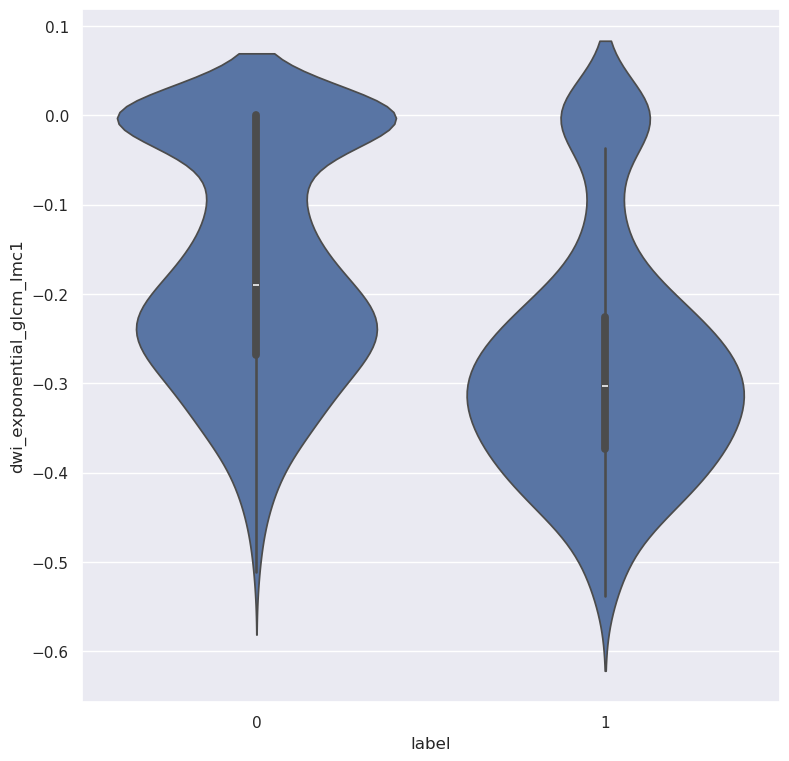

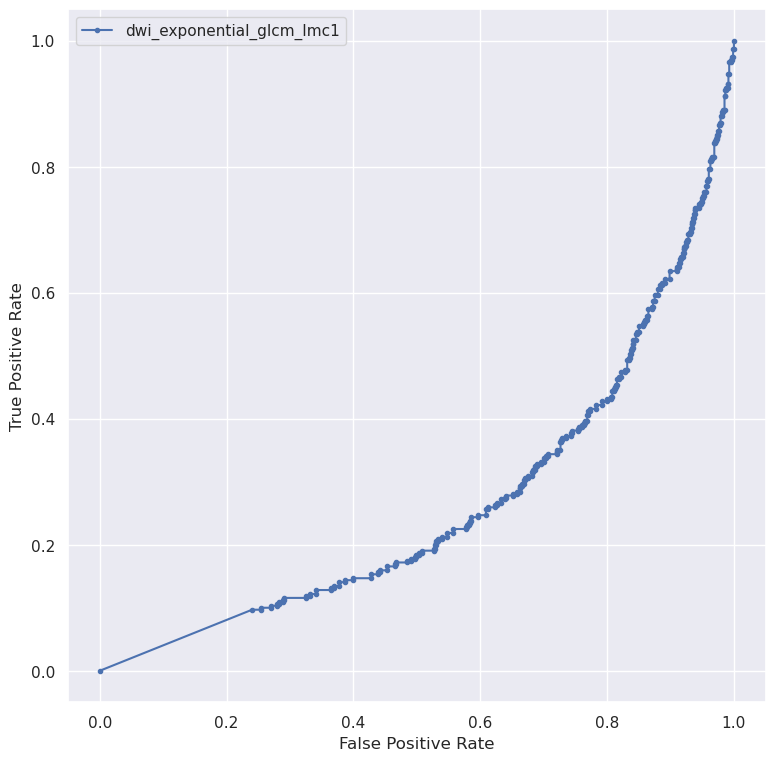

In [11]:
dropdown = 'dwi_exponential_glcm_Imc1' 

import seaborn as sns
from matplotlib import pyplot
from sklearn.metrics import roc_curve
sns.set(rc={'figure.figsize':(9,9)})
sns.violinplot(x=Y_train, y=X_train[dropdown])

plt.figure(0)
lr_fpr, lr_tpr, _ = roc_curve(Y_train, X_train[dropdown])
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label=dropdown)
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

# Lets count how many features are statistically significant between groups after the multiple comparisons correction

In [12]:
print(sum(i < 0.05 for i in corrected_p_value))

1060


# Lets train a model using 1 feature for every 15 patients we have on the training set

In [12]:
num_features_model = round(X_train[dropdown].shape[0]/15)
train_df = train_auc_pvals_df.sort_values(by='p-value', ascending=True)
selected_features = train_df.index[0:num_features_model]

X_train_new = X_train[selected_features]

In [13]:
selected_features

Index(['dwi_square_ngtdm_Strength', 'dwi_exponential_glcm_Imc1',
       'dwi_log-sigma-3-mm-3D_firstorder_Skewness',
       'dwi_exponential_glszm_GrayLevelNonUniformityNormalized',
       'dwi_exponential_ngtdm_Strength',
       'dwi_log-sigma-3-mm-3D_firstorder_Kurtosis',
       'dwi_exponential_glszm_GrayLevelVariance',
       'dwi_square_firstorder_Skewness', 'dwi_exponential_firstorder_Skewness',
       'dwi_exponential_glcm_ClusterProminence',
       'dwi_exponential_glszm_HighGrayLevelZoneEmphasis',
       'dwi_wavelet2-LL_firstorder_Skewness',
       'dwi_exponential_glrlm_GrayLevelVariance',
       'dwi_exponential_glcm_ClusterShade',
       'dwi_exponential_glszm_SmallAreaHighGrayLevelEmphasis',
       'dwi_exponential_gldm_SmallDependenceHighGrayLevelEmphasis',
       'dwi_exponential_glrlm_ShortRunHighGrayLevelEmphasis',
       'dwi_square_ngtdm_Busyness', 'dwi_original_firstorder_Skewness',
       'dwi_log-sigma-2-mm-3D_firstorder_Skewness',
       'dwi_wavelet2-LL_ngtdm_S

## Select optimization metric

In [14]:
optimization_metric = "AUC" #["AUC", "MCC", "Kappa","F1", "Accuracy", "Sensitivity", "Specificity", "PPV", "NPV", "BalancedAcc"]

if optimization_metric == "AUC":
    score_str = 'roc_auc'
elif optimization_metric == "MCC":
    score_str = make_scorer(matthews_corrcoef)
elif optimization_metric == "Kappa":
    score_str = make_scorer(cohen_kappa_score)
elif optimization_metric == "F1":
    score_str = 'f1'
elif optimization_metric == "Accuracy":
    score_str = 'accuracy'
elif optimization_metric == "Sensitivity":
    score_str = 'recall'
elif optimization_metric == "Specificity":
    score_str = make_scorer(recall_score, pos_label=0)
elif optimization_metric == "PPV":
    score_str = 'precision'
elif optimization_metric == "NPV":
    score_str = make_scorer(precision_score, pos_label=0)
elif optimization_metric == "BalancedAcc":
    score_str = 'balanced_accuracy'

score_group = {'AUC': 'roc_auc', 'MCC': make_scorer(matthews_corrcoef) ,
               'Kappa': make_scorer(cohen_kappa_score), 
               'F1': 'f1', 'Accuracy': 'accuracy', 
               'Sensitivity': 'recall', 
               'Specificity': make_scorer(recall_score, pos_label=0),
               'PPV': 'precision', 
               'NPV': make_scorer(precision_score, pos_label=0),
               'BalancedAcc': 'balanced_accuracy'}

score_refit_str = optimization_metric

## Classifier Selection

In [15]:
SVM_classifier = True
LogisticRegression_classifier = True
RandomForest_classifier = True
NaiveBayes_classifier = True
KNN_classifier = True
GradientBoosting_classifier = True

In [16]:
df_ncv_scores = pd.DataFrame(columns = ['Classifier', 'Nested-CV Mean', 'Nested-CV Std'])
if SVM_classifier:
    pipe_svc = make_pipeline(StandardScaler(),
                             VarianceThreshold(),
                             SVC(random_state=random_state_value))

    param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

    param_grid_svc = [{'svc__C': param_range, 
                  'svc__kernel': ['linear']},
                  {'svc__C': param_range, 
                  'svc__gamma': param_range, 
                  'svc__kernel': ['rbf']}]

    gs_svc = GridSearchCV(estimator=pipe_svc, 
                      param_grid=param_grid_svc, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_scv = cross_val_score(gs_svc, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['SVM'], 'Nested-CV Mean': [np.mean(scores_scv)], 'Nested-CV Std': [np.std(scores_scv)]}, columns = ['Classifier', 'Nested-CV Mean', 'Nested-CV Std'])
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)
    
if LogisticRegression_classifier:
    pipe_lr = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            LogisticRegression(random_state=random_state_value, #penalty='elasticnet', 
                                           solver='saga'))

    param_range_lr = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

    param_range_penalty = ['l1']

    param_grid_lr = {'logisticregression__penalty': param_range_penalty,
                     'logisticregression__C': param_range_lr,
                     }

    gs_lr = GridSearchCV(estimator=pipe_lr, 
                      param_grid=param_grid_lr, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_lr = cross_val_score(gs_lr, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Logistic Regression'], 'Nested-CV Mean': [np.mean(scores_lr)], 'Nested-CV Std': [np.std(scores_lr)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

if RandomForest_classifier:
    pipe_rf = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            RandomForestClassifier(n_jobs=-1, random_state=random_state_value))

    param_range_rf = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

    param_grid_rf = {'randomforestclassifier__n_estimators': param_range_rf,
                    'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

    gs_rf = GridSearchCV(estimator=pipe_rf, 
                      param_grid=param_grid_rf, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_rf = cross_val_score(gs_rf, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Random Forest'], 'Nested-CV Mean': [np.mean(scores_rf)], 'Nested-CV Std': [np.std(scores_rf)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

if NaiveBayes_classifier:
    pipe_nb = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            GaussianNB())

    param_grid_nb = {}

    gs_nb = GridSearchCV(estimator=pipe_nb, 
                      param_grid=param_grid_nb, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_nb = cross_val_score(gs_nb, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Naive Bayes'], 'Nested-CV Mean': [np.mean(scores_nb)], 'Nested-CV Std': [np.std(scores_nb)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

if KNN_classifier:
    pipe_knn = make_pipeline(StandardScaler(),
                             VarianceThreshold(),
                             KNeighborsClassifier(n_jobs=-1)) # random_state=random_state_value, 

    param_n_neighbors_knn = [2, 3, 4, 5, 6, 7, 8]

    param_grid_knn = {'kneighborsclassifier__n_neighbors': param_n_neighbors_knn,
                    'kneighborsclassifier__weights': ['uniform', 'distance']}

    gs_knn = GridSearchCV(estimator=pipe_knn, 
                      param_grid=param_grid_knn, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_knn = cross_val_score(gs_knn, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['KNN'], 'Nested-CV Mean': [np.mean(scores_knn)], 'Nested-CV Std': [np.std(scores_knn)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

if GradientBoosting_classifier:
    pipe_gb = make_pipeline(StandardScaler(),
                            VarianceThreshold(),
                            GradientBoostingClassifier(random_state=random_state_value))

    param_range_gb = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
    param_learnrate_gb = [0.0001, 0.001, 0.01, 0.1]

    param_grid_gb = {'gradientboostingclassifier__n_estimators': param_range_gb,
                    'gradientboostingclassifier__learning_rate': param_learnrate_gb}

    gs_gb = GridSearchCV(estimator=pipe_gb, 
                      param_grid=param_grid_gb, 
                      scoring=score_str, 
                      refit=True,
                      cv=2,
                      n_jobs=-1)

    scores_gb = cross_val_score(gs_gb, X_train_new, y_train, 
                            scoring=score_str, cv=5)
    
    df_score = pd.DataFrame(data={'Classifier': ['Gradient Boosting'], 'Nested-CV Mean': [np.mean(scores_gb)], 'Nested-CV Std': [np.std(scores_gb)]})
    df_ncv_scores = pd.concat([df_ncv_scores, df_score], ignore_index=True)

df_ncv_scores.sort_values(by=df_ncv_scores.columns[1], ascending=False)

KeyboardInterrupt: 

## Select classifier to train/fine-tune model

In [33]:
selected_model = 'SVM'

number_folds = 5

## Train/Fine-tune selected model

In [34]:
if selected_model == 'SVM':
  pipe_svc = make_pipeline(StandardScaler(),
                           VarianceThreshold(),
                           SVC(random_state=random_state_value))

  param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

  param_grid_svc = [{'svc__C': param_range, 
                'svc__kernel': ['linear']},
                {'svc__C': param_range, 
                'svc__gamma': param_range, 
                'svc__kernel': ['rbf']}]

  gs_svc = GridSearchCV(estimator=pipe_svc, 
                    param_grid=param_grid_svc, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)

  gs = gs_svc.fit(X_train_new, y_train)
  clf_svc = gs.best_estimator_
          
elif selected_model == 'LogisticRegression':
  pipe_lr = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          LogisticRegression(penalty='elasticnet', random_state=random_state_value,
                                            solver='saga'))

  param_range_lr = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

  param_l1_ratio_lr = np.linspace(0,1,11)

  param_range_penalty = ['l1']

  param_grid_lr = {'logisticregression__penalty': param_range_penalty,
                   'logisticregression__C': param_range_lr}

  gs_lr = GridSearchCV(estimator=pipe_lr, 
                    param_grid=param_grid_lr, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)

  gs = gs_lr.fit(X_train_new, y_train)
  clf_lr = gs.best_estimator_

elif selected_model == 'RandomForest':
  pipe_rf = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          RandomForestClassifier(n_jobs=-1, random_state=random_state_value))

  param_range_rf = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

  param_grid_rf = {'randomforestclassifier__n_estimators': param_range_rf,
                  'randomforestclassifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}

  gs_rf = GridSearchCV(estimator=pipe_rf, 
                    param_grid=param_grid_rf, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_rf.fit(X_train_new, y_train)
  clf_rf = gs.best_estimator_

elif selected_model == 'NaiveBayes':
  pipe_nb = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          GaussianNB())

  param_grid_nb = {}

  gs_nb = GridSearchCV(estimator=pipe_nb, 
                    param_grid=param_grid_nb, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_nb.fit(X_train_new, y_train)
  clf_nb = gs.best_estimator_
  
elif selected_model == 'KNN':
  pipe_knn = make_pipeline(StandardScaler(),
                           VarianceThreshold(),
                           KNeighborsClassifier(n_jobs=-1)) # random_state=random_state_value, 

  param_n_neighbors_knn = [2, 3, 4, 5, 6, 7, 8]

  param_grid_knn = {'kneighborsclassifier__n_neighbors': param_n_neighbors_knn,
                  'kneighborsclassifier__weights': ['uniform', 'distance']}

  gs_knn = GridSearchCV(estimator=pipe_knn, 
                    param_grid=param_grid_knn, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_knn.fit(X_train_new, y_train)
  clf_knn = gs.best_estimator_
  
elif selected_model == 'GradientBoosting':
  pipe_gb = make_pipeline(StandardScaler(),
                          VarianceThreshold(),
                          GradientBoostingClassifier(random_state=random_state_value))

  param_range_gb = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
  param_learnrate_gb = [0.0001, 0.001, 0.01, 0.1]

  param_grid_gb = {'gradientboostingclassifier__n_estimators': param_range_gb,
                  'gradientboostingclassifier__learning_rate': param_learnrate_gb}

  gs_gb = GridSearchCV(estimator=pipe_gb, 
                    param_grid=param_grid_gb, 
                    scoring=score_group, 
                    refit=score_refit_str,
                    cv=number_folds,
                    n_jobs=-1)
  gs = gs_gb.fit(X_train_new, y_train)
  clf_gb = gs.best_estimator_

print(gs.best_params_)
for key in score_group:
    if len(gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1])>1:
        print('CV %s: %.3f +/- %.3f' % (key,
                                        gs.cv_results_['mean_test_'+key][gs.cv_results_['rank_test_'+key]==1][0],
                                        gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1][0]))
    else:
        print('CV %s: %.3f +/- %.3f' % (key,
                                        gs.cv_results_['mean_test_'+key][gs.cv_results_['rank_test_'+key]==1],
                                        gs.cv_results_['std_test_'+key][gs.cv_results_['rank_test_'+key]==1]))

/home/jose/anaconda3/envs/tfg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jose/anaconda3/envs/tfg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jose/anaconda3/envs/tfg/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jose/anaconda

{'svc__C': 1000.0, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
CV AUC: 0.816 +/- 0.024
CV MCC: 0.438 +/- 0.073
CV Kappa: 0.416 +/- 0.070
CV F1: 0.543 +/- 0.057
CV Accuracy: 0.790 +/- 0.026
CV Sensitivity: 0.516 +/- 0.020
CV Specificity: 1.000 +/- 0.000
CV PPV: 0.715 +/- 0.081
CV NPV: 0.807 +/- 0.016
CV BalancedAcc: 0.684 +/- 0.031


/tmp/ipykernel_71751/1502408736.py:130: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('CV %s: %.3f +/- %.3f' % (key,


# Assess Model performance on the held-out test dataset

In [38]:
train_metrics_df = train_auc_pvals_corrected_df.sort_values(by='corrected p-value', ascending=True)
train_metrics_df.head()

auc_test_list, sens_test_list, spec_test_list = ([] for i in range(3))
for indx in range(5):
  feature_name = train_metrics_df.index[indx]
  if train_metrics_df.iloc[indx]['Pos.vs.Neg.'] == '>':
    fpr, tpr, thresholds = metrics.roc_curve(y_test, X_test[feature_name], pos_label=1)
    pred = np.zeros(X_test[feature_name].shape)
    pred[X_test[feature_name] >= train_metrics_df.iloc[indx]['Cutoff-Threshold']] = 1
    pred[X_test[feature_name] < train_metrics_df.iloc[indx]['Cutoff-Threshold']] = 0
  else:
    fpr, tpr, thresholds = metrics.roc_curve(y_test, X_test[feature_name], pos_label=0)
    pred[X_test[feature_name] < train_metrics_df.iloc[indx]['Cutoff-Threshold']] = 1
    pred[X_test[feature_name] >= train_metrics_df.iloc[indx]['Cutoff-Threshold']] = 0
  auc = metrics.auc(fpr, tpr)
  tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
  sensitivity = tp / (tp+fn)
  specificity = tn / (tn+fp)
  auc_test_list.append(auc)
  sens_test_list.append(sensitivity)
  spec_test_list.append(specificity)

test_auc_pvals_df = pd.DataFrame(list(zip(auc_test_list, 
                                           sens_test_list, spec_test_list)), 
                                  index = train_metrics_df.index[0:5],
                                  columns =['AUC', 'Sensitivity', 
                                            'Specificity'])
test_auc_pvals_df

,AUC,Sensitivity,Specificity
dwi_square_ngtdm_Strength,0.708418,0.676190,0.659176
dwi_exponential_glcm_Imc1,0.654575,0.600000,0.651685
dwi_log-sigma-3-mm-3D_firstorder_Skewness,0.692920,0.609524,0.662921
dwi_exponential_glszm_GrayLevelNonUniformityNormalized,0.657517,0.580952,0.662921
dwi_exponential_ngtdm_Strength,0.676529,0.676190,0.625468


## Plot Confusion Matrix of tuned model on held-out test dataset prediction

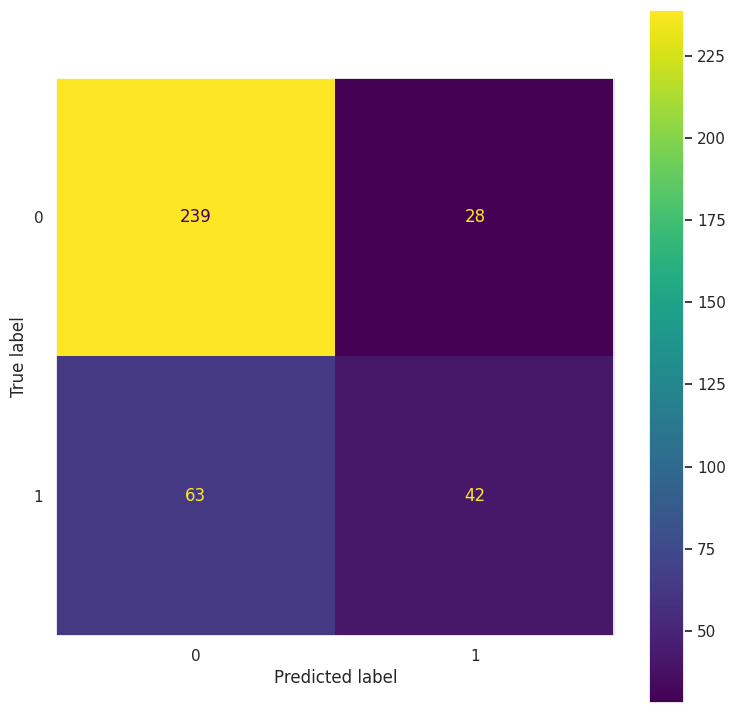

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gs, X_test[selected_features], y_test)
plt.grid(None)
plt.show()

## Obtain performance metrics of model on the held-out test set

In [40]:
clf = gs
print('AUC: %.3f' % (roc_auc_score(y_test, clf.predict(X_test[selected_features]))))
print('MCC: %.3f' % (matthews_corrcoef(y_test, clf.predict(X_test[selected_features]))))
print('Kappa: %.3f' % (cohen_kappa_score(y_test, clf.predict(X_test[selected_features]))))
print('F1: %.3f' % (f1_score(y_test, clf.predict(X_test[selected_features]))))
print('Accuracy: %.3f' % (accuracy_score(y_test, clf.predict(X_test[selected_features]))))
print('Sensitivity: %.3f' % (recall_score(y_test, clf.predict(X_test[selected_features]))))
print('Specificity: %.3f' % (recall_score(y_test, clf.predict(X_test[selected_features]), pos_label=0)))
print('PPV: %.3f' % (precision_score(y_test, clf.predict(X_test[selected_features]))))
print('NPV: %.3f' % (precision_score(y_test, clf.predict(X_test[selected_features]), pos_label=0)))
print('BalancedAcc: %.3f\n\n' % (balanced_accuracy_score(y_test, clf.predict(X_test[selected_features]))))

AUC: 0.648
MCC: 0.340
Kappa: 0.328
F1: 0.480
Accuracy: 0.755
Sensitivity: 0.400
Specificity: 0.895
PPV: 0.600
NPV: 0.791
BalancedAcc: 0.648




# Shap Analysis for model explainability

In [41]:
from copy import deepcopy

# get preprocessing (normalized and remove near or zero variance features)
best_estimator_preprocessing_pipeline = deepcopy(gs.best_estimator_)
best_estimator_preprocessing_pipeline.steps.pop(2)

# get classifier
model = gs.best_estimator_.steps[2][1]

In [42]:
X_transformed = pd.DataFrame(best_estimator_preprocessing_pipeline.transform(X_train), columns=gs.best_estimator_.steps[1][1].get_feature_names_out())

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- adc_exponential_firstorder_10Percentile
- adc_exponential_firstorder_90Percentile
- adc_exponential_firstorder_Energy
- adc_exponential_firstorder_Entropy
- adc_exponential_firstorder_InterquartileRange
- ...


In [43]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer(X_transformed)
shap.plots.beeswarm(shap_values[:,:,1])

/home/jose/anaconda3/envs/tfg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'sklearn.svm._classes.SVC'>